# Multimessenger - Supernova

## Refactor

I refactored the code to work more efficiently and to be more modular so that it can be integrated into different studies smoothly. <br>

Main difference is now there are different classes handling different tasks. <br>
 - `multimessenger.supernova.Supernova_Models` handles only the models and fluxes
 - `multimessenger.supernova.Nucleus` creates a Xenon atom, pure or isotope, computes cross sections
 - `multimessenger.supernova.interactions` accepts a model, and creates a nuclei to handle the interactions.

### Models
Let's have a look at the Supernova Models

In [1]:
import numpy as np
import astropy.units as u
from snewpy.neutrino import Flavor

> On midway do the following first; <br>

I manually created a folder called `mma_data` and inside it I called <br>
`python -c 'import snewpy; snewpy.get_models()'` <br>
and installed 2 snewpy models. They are saved in `mma_data/SNEWPY_models/` which we give to config file. <br>

I store everything else in the same folder for now. Notice, normally, you don't want to keep (especially) heavy files in your home folder. The ideal would be to store all in the common /dali/ storage where everyone can load the same file instead of everyone creating it for themselves.

In [ ]:
import configparser
config = configparser.ConfigParser()
config['paths'] = {'snewpy_models': './mma_data/SNEWPY_models/',
                   'processed_data': './mma_data/',}
config['wfsim'] = {'instruction_path': './mma_data/',
                   'sim_folder': './mma_data/',}
with open('./mma_data/temp_config.config', 'w') as configfile:
    config.write(configfile)

Import the Supernova Models, and to have a quick check, the model list.

In [2]:
from multimessenger.supernova import Supernova_Models

These are the Models we grab from `snewpy` (some special models are ignored for now). Each of these models have some variations.

In [3]:
print(Supernova_Models.models_list)

['Bollig_2016', 'Fornax_2021', 'Kuroda_2020', 'Nakazato_2013', 'OConnor_2015', 'Sukhbold_2015', 'Tamborra_2014', 'Walk_2018', 'Walk_2019', 'Zha_2021']


In [4]:
# create nakazato model 
SN_Nakazato = Supernova_Models.Models("Nakazato_2013", config_file="./local_conf.conf")

> Nakazato_2013 is created, load a progenitor by function call.


In [5]:
# call the model by filename or index
SN_Nakazato(index=5) # brings the attributes

> You chose ~wisely~ ->	   [5]	nakazato-shen-z0.004-t_rev200ms-s13.0.fits
>>>>> Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits.pickle
> Retrieving object self.storageNakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits.pickle


/mnt/c/Users/bj7780/Desktop/Kara/GitHub/XENON/multimessenger/multimessenger/supernova/snewpy_models.py:85: FutureWarning: Initializing this model with a filename is deprecated. Instead, use keyword arguments ['progenitor_mass', 'revival_time', 'metallicity', 'eos']. See `Nakazato_2013.param`, `Nakazato_2013.get_param_combinations()` for more info.
  models_dict[self.name](f)
/mnt/c/Users/bj7780/Desktop/Kara/GitHub/XENON/multimessenger/multimessenger/supernova/snewpy_models.py:66: FutureWarning: Initializing this model with a filename is deprecated. Instead, use keyword arguments ['progenitor_mass', 'revival_time', 'metallicity', 'eos']. See `Nakazato_2013.param`, `Nakazato_2013.get_param_combinations()` for more info.
  model = models_dict[self.name](file_to_load, **model_kwargs)


Now we already have all the attributes from `snewpy` in our `SN_model` object.

In [6]:
SN_Nakazato

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev200ms-s13.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $13$ $\mathrm{M_{\odot}}$|
|EOS | SHEN |
|Metallicity | 0.004 |
|Revival time | $200$ $\mathrm{ms}$|
|file name| Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits.pickle
|duration | 20.05 s|
|time range| (-0.05 s, 20.0 s)

Some parameters of the model can be set in advance, such as the neutrino energies and times to calculate the fluxes for. By default the neutrino energies are computed for 100 values between 0 and 200 MeV. The times are used as they are given in the model by default. however, different sampling is possible.

In [7]:
print(f"Energies in ({SN_Nakazato.neutrino_energies[[0,-1]]}) shape:{SN_Nakazato.neutrino_energies.shape}")
print(f"Time in {SN_Nakazato.times[[0,-1]]} shape:{SN_Nakazato.times.shape}")

Energies in ([ 0. 75.] MeV) shape:(200,)
Time in [-0.05 20.  ] s shape:(391,)


In [8]:
# # you can manually set params
# SN_Nakazato.set_params(neutrino_energies=np.linspace(0, 50, 250))
# print(f"Energies in ({SN_Nakazato.neutrino_energies[[0,-1]]}) shape:{SN_Nakazato.neutrino_energies.shape}")

We can now compute the fluxes and scale them at any distance. 

In [9]:
# alternativley you can change them on the fly
SN_Nakazato.compute_model_fluxes(neutrino_energies=np.linspace(0, 75, 200), force=1)

Looping:   0%|          | 0/391 [00:00<?, ?it/s]

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits.pickle!



We can also scale the fluxes at a given distance.

In [10]:
fluxes_at10 = SN_Nakazato.scale_fluxes(distance=10)
fluxes_at5 = SN_Nakazato.scale_fluxes(distance=5*u.kpc)

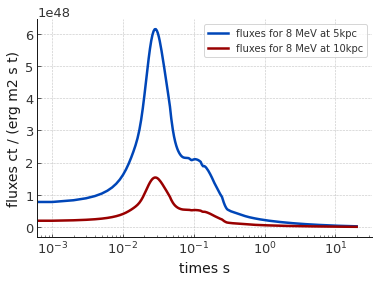

In [11]:
import matplotlib.pyplot as plt
plt.style.use('customstyle.mplstyle')
from matplotlib.colors import LogNorm
from snewpy.neutrino import Flavor

plt.semilogx(SN_Nakazato.times, fluxes_at5[Flavor.NU_E][:,20], label=f'fluxes for {SN_Nakazato.neutrino_energies[20]:.0f} '\
                                                                     'at 5kpc')

plt.semilogx(SN_Nakazato.times, fluxes_at10[Flavor.NU_E][:,20], label=f'fluxes for {SN_Nakazato.neutrino_energies[20]:.0f} '\
                                                                      'at 10kpc')
plt.legend()
plt.xlabel(f"times {SN_Nakazato.times.unit}")
plt.ylabel(f"fluxes {fluxes_at10[Flavor.NU_E].unit}");

### Target

In order to study the interactions we can either create a (single or a mixture of) isotope and pass it to the `interactions` script or tell the interactions script to create this isotope(s) for us. <br>
In either case one needs to pass a supernova model to calculate the interactions for. <br>
At a later stage, one can specify a distance and a target volume to compute the total of the expected interactions.

In [12]:
from multimessenger.supernova.Nucleus import Target
from multimessenger.supernova.Xenon_Atom import ATOM_TABLE
from multimessenger.supernova.interactions import Interactions

In [13]:
# ATOM_TABLE

We can have a look at a single atom

In [15]:
print("Target we load", ATOM_TABLE['Xe131'])
singleXe = Target(ATOM_TABLE['Xe131'], pure=True) # pure means setting the abundance to =1 
singleXe

Target we load {'Type': 'Xe131', 'MassNum': 131, 'AtomicNum': 54, 'Mass': 130.9050824, 'Spin': 1.5, 'Fraction': 0.212324}


### The Target<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Values</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Type</th>
      <td>Xe131</td>
    </tr>
    <tr>
      <th>MassNum</th>
      <td>131</td>
    </tr>
    <tr>
      <th>AtomicNum</th>
      <td>54</td>
    </tr>
    <tr>
      <th>Mass</th>
      <td>130.905082</td>
    </tr>
    <tr>
      <th>Spin</th>
      <td>1.5</td>
    </tr>
    <tr>
      <th>Fraction</th>
      <td>0.212324</td>
    </tr>
  </tbody>
</table>
</div><br>


In [16]:
recoil_en = np.linspace(0,30,100) * u.keV
neutrino_en = SN_Nakazato.neutrino_energies

formfac = singleXe.form_factor(np.linspace(0,150,100) * u.keV)
crosssec = singleXe.nN_cross_section(neutrino_en, recoil_en)

/tmp/ipykernel_327/3748069102.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax2.pcolormesh(crosssec * 1e43, cmap='PuBu') #, norm=LogNorm())


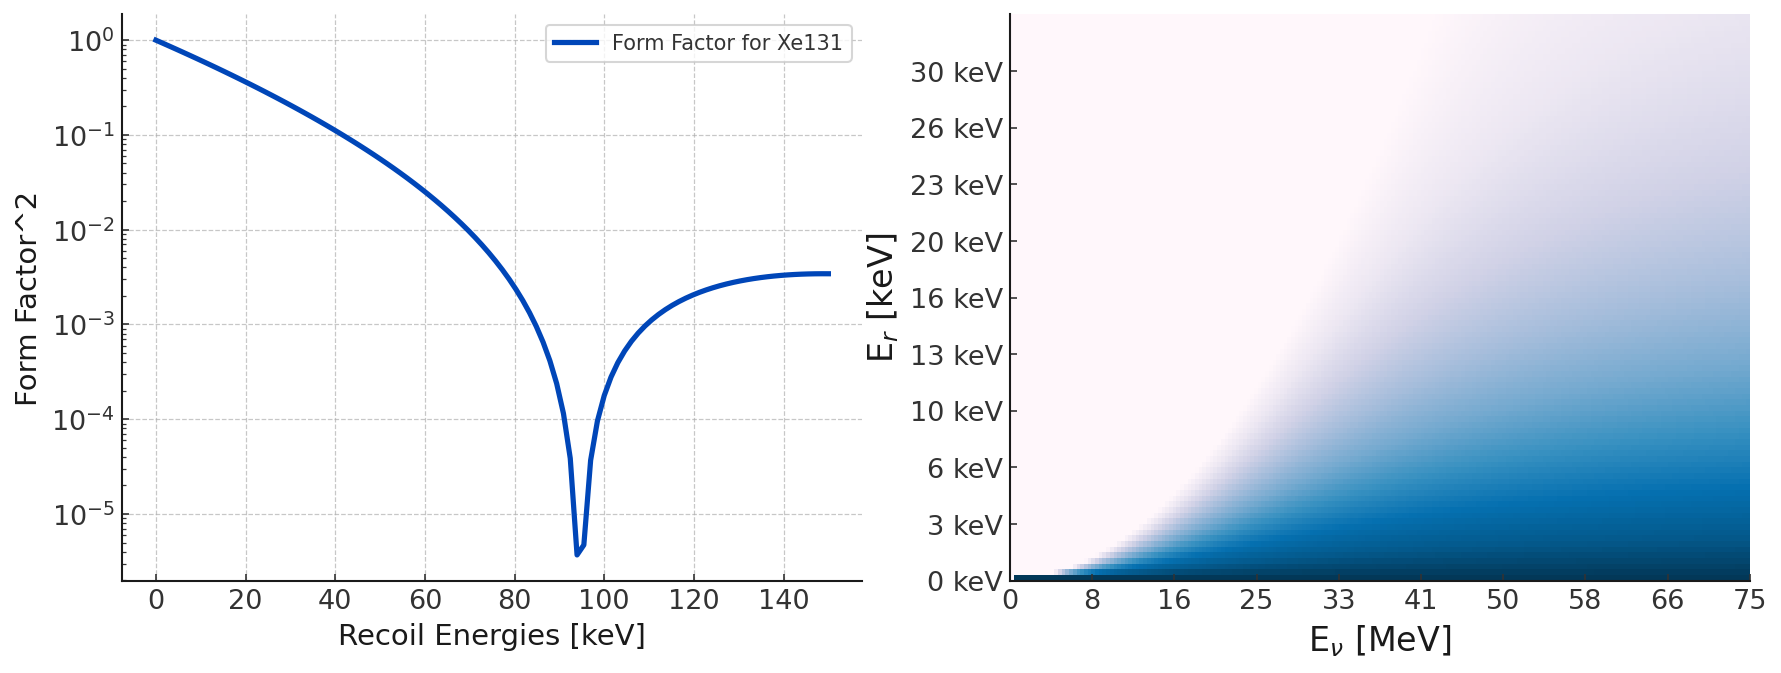

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
ax1.semilogy(np.linspace(0,150,100) * u.keV, formfac**2, label='Form Factor for Xe131');
ax1.set_xlabel(f'Recoil Energies [{recoil_en.unit}]')
ax1.set_ylabel('Form Factor^2')
ax1.legend();

cb = ax2.pcolormesh(crosssec * 1e43, cmap='PuBu') #, norm=LogNorm())
ax2.set_xlabel(r'E$_\nu$ [MeV]', fontsize=16)
ax2.set_ylabel(r'E$_r$ [keV]', fontsize=16)
ax2.set_xticks(ticks=np.linspace(0, crosssec.shape[1], 10), labels=np.linspace(neutrino_en[0], neutrino_en[-1], 10, dtype=int).value)
ax2.set_yticks(ticks=np.arange(0, crosssec.shape[0], 10), labels=np.linspace(recoil_en[0], recoil_en[-1], 10, dtype=int));

*Sassy*

### Interactions
Now let's pass -or tell interactions to use this nuclei together with the nakazato model

In [18]:
# Int = Interactions(SN, Nuclei='Xenon', isotope='mix')
Int = Interactions(SN_Nakazato, Nuclei='Xenon', isotope='Xe131')

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits_interaction.pickle!



The interactions are also stored similar to Models, as both flux computations and the interaction rates can take some time. This memory of already executed objects help us work faster!

Now that we have a model and a target, we can compute their interactions. By default it computes the interactions rates at 100 recoil energies uniformly distributed between 0 and 20 keV. This can be changed either from the object attributes or on the fly when calculating the interaction rates. <br>
`Int.recoil_energies = np.lispace(1,10,50) * u.keV` <br>
`Int.compute_interaction_rates(recoil_energies = np.lispace(1,10,50))` <br><br>
Both are valid, if no unit is passed, the unit is assumed to be keV.

In [19]:
Int.compute_interaction_rates(force=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

> Computed the total rates at the source for 1 atom (not scaled)


That was fast innit?

Now we have differential rates over time and over recoil energies as follows;
$$\frac{dR}{dE_R} = \sum_{\nu_\beta} N_{Xe}
               \int_{E_{min}^{\nu}} dE_\nu f_\nu(E_\nu)\frac{d\sigma}{dE_R}(E_\nu, E_R)$$
               
$$\frac{dR}{dt} = \sum N_{Xe}\int_{E_{min}^\nu} = f_\nu(E_\nu,t)
               \int_{E_{R}^{min}}^{E_{R}^{max}} dE_R \frac{d\sigma}{dE_R}(E_\nu, E_R)$$

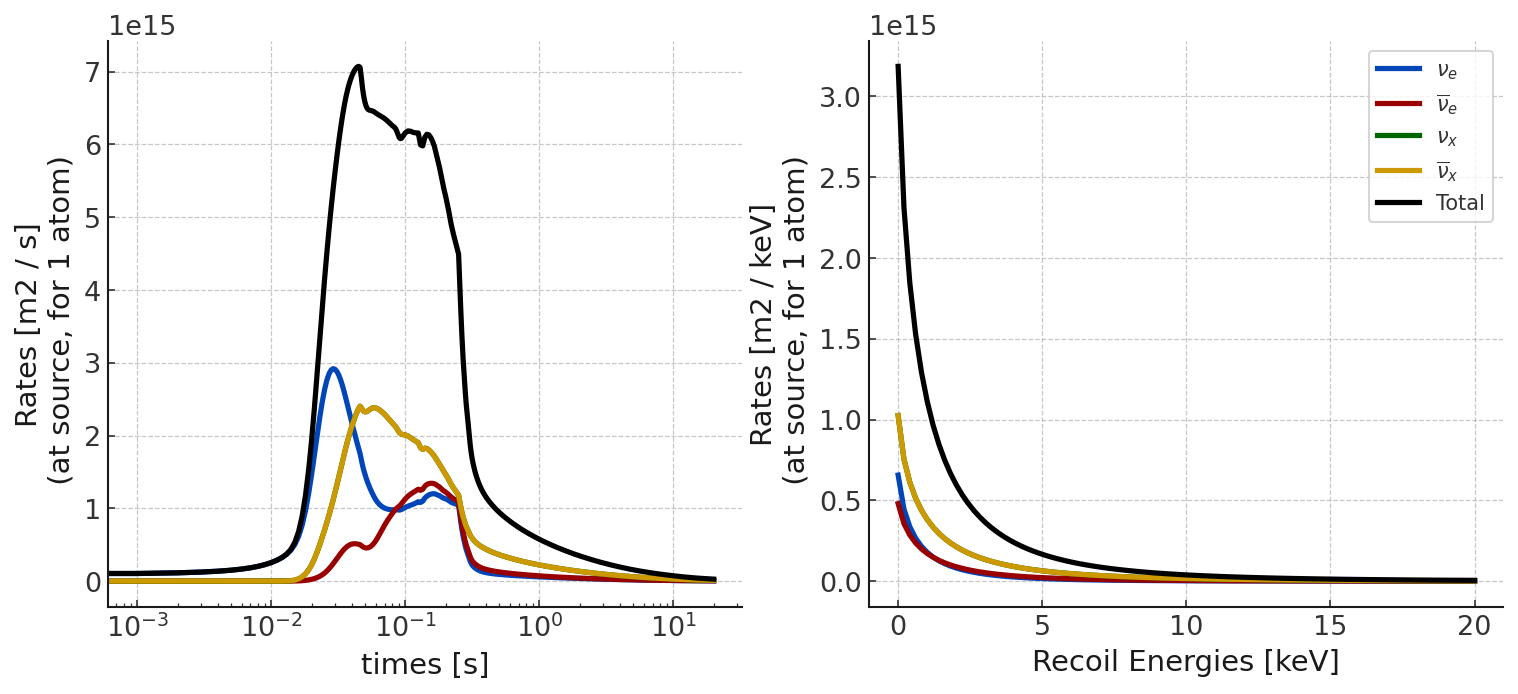

In [20]:
Int.plot_rates(scaled=False)

Notice that the rates are suuuper high. This is because so far we haven't told where this model is located or how many atoms our target has! <br>
`Int.scale_rates()` accepts distance, volume, and number of atoms per ton as arguments. The number of atoms per ton is by default the number of Xenon atoms per ton. <br> both the distance and the volume can be given with or without units. If there are no units, it assumes kpc for the distance and tons for the volume. 

In [21]:
scaled_rate_per_recoils, scaled_rate_per_time = Int.scale_rates(distance=20, volume=5.9)

You can now either use the scaled rates or the object also remembers what was the last scaled rates, and can use it to plot.

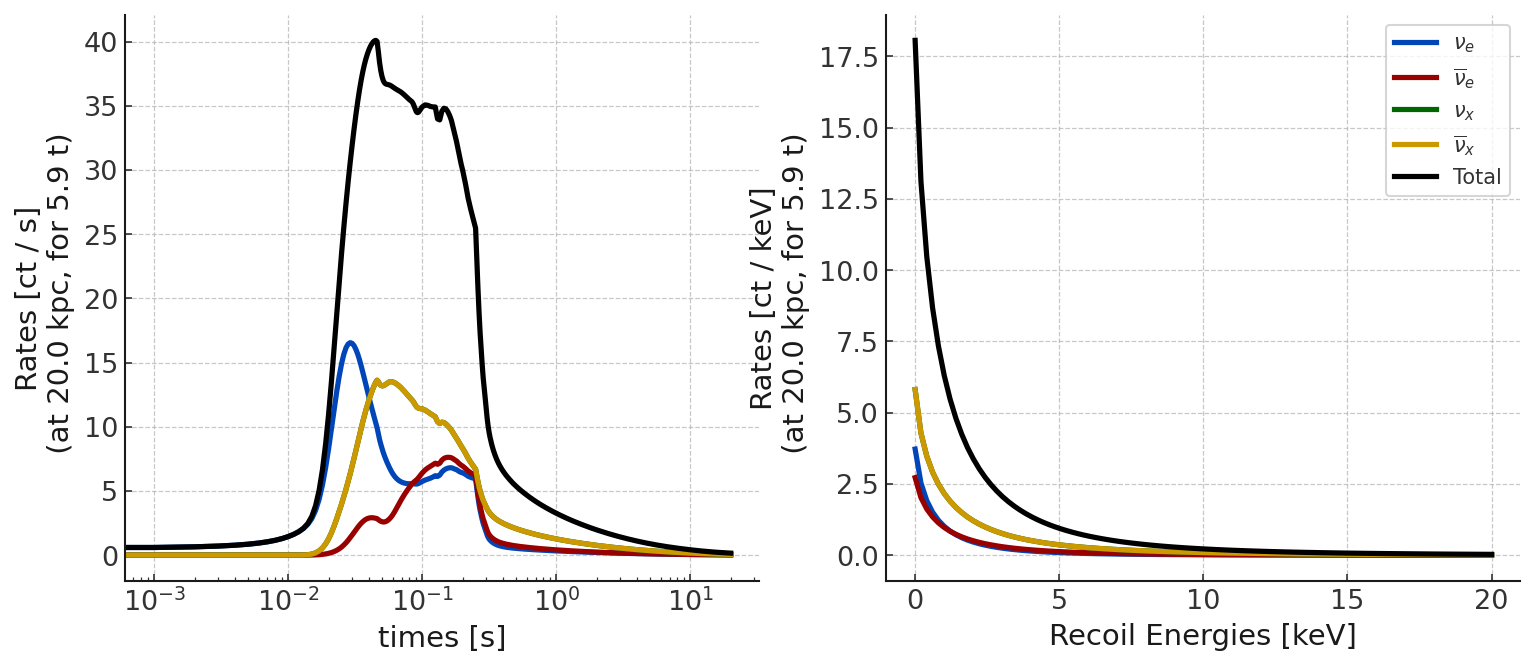

In [22]:
Int.plot_rates(scaled=True)

Now, those are more realistic numbers. Logically, the area under both "Total" curves should give the same number which is the exact number of expected interactions.

In [59]:
np.trapz(scaled_rate_per_recoils['Total'], Int.recoil_energies), np.trapz(scaled_rate_per_time['Total'], Int.Model.times)

(<Quantity 23.84089065 ct>, <Quantity 23.84089065 ct>)

In [23]:
Int

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev200ms-s13.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $13$ $\mathrm{M_{\odot}}$|
|EOS | SHEN |
|Metallicity | 0.004 |
|Revival time | $200$ $\mathrm{ms}$|
|file name| Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits.pickle
|duration | 20.05 s|
|time range| (-0.05 s, 20.0 s)
|Interaction file| Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits_interaction.pickle
|Target | Xe131 Xenon
|Computed, scaled | True, True
|distance | 20.0 kpc
|volume | 5.9 t
|Expected Total | 24 ct

In [24]:
Int.scale_rates(distance=10, volume=40);
Int

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev200ms-s13.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $13$ $\mathrm{M_{\odot}}$|
|EOS | SHEN |
|Metallicity | 0.004 |
|Revival time | $200$ $\mathrm{ms}$|
|file name| Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits.pickle
|duration | 20.05 s|
|time range| (-0.05 s, 20.0 s)
|Interaction file| Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits_interaction.pickle
|Target | Xe131 Xenon
|Computed, scaled | True, True
|distance | 10.0 kpc
|volume | 40.0 t
|Expected Total | 647 ct

---
### Compare a mixture of isotopes

Now, let's check how much of a change we get, if we consider a **mixture of isotopes**.

In [27]:
Int2 = Interactions(SN_Nakazato, Nuclei='Xenon', isotope='mix')

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits_interaction.pickle!



In [28]:
# change the name of the file so that it doesn't overwrite
print("Before: ", Int2.interaction_file)
Int2.interaction_file = 'Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits_interaction-mix.pickle'
print("After: ", Int2.interaction_file)

Before:  Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits_interaction.pickle
After:  Nakazato_2013-nakazato-shen-z0_004-t_rev200ms-s13_0_fits_interaction-mix.pickle


In [29]:
Int2.compute_interaction_rates()

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

> Computed the total rates at the source for 1 atom (not scaled)


In [30]:
a,b = Int2.scale_rates(distance=10, volume=5.9);
c,d = Int.scale_rates(distance=10, volume=5.9);

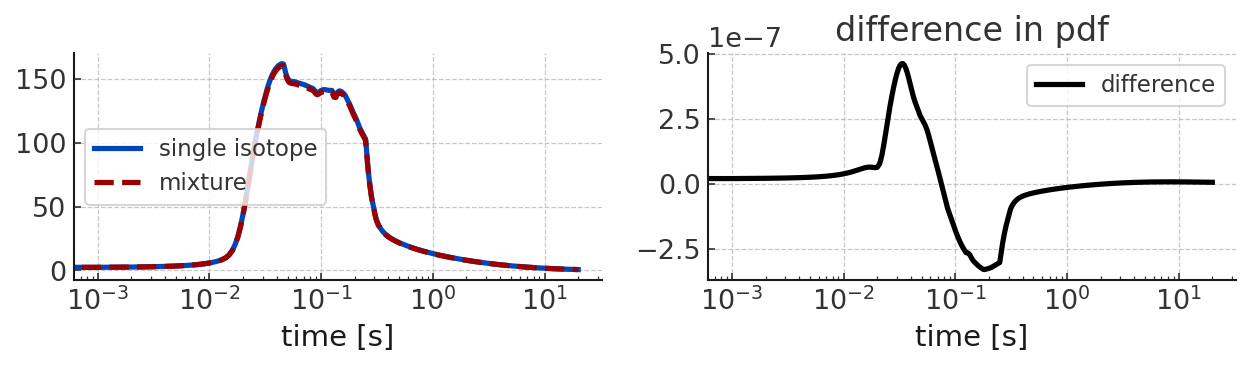

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,2))
ax1.semilogx(Int2.Model.times, b['Total'], label='single isotope')
ax1.semilogx(Int.Model.times, d['Total'], label='mixture', ls='--');

ax1.set_xlabel('time [s]')
ax1.legend(fontsize=11);

e = b['Total']/np.sum(b['Total']) - d['Total']/np.sum(d['Total'])
ax2.semilogx(Int.Model.times, e, color='k', label='difference')
ax2.set_title("difference in pdf")
ax2.set_xlabel('time [s]')
ax2.legend(fontsize=11);

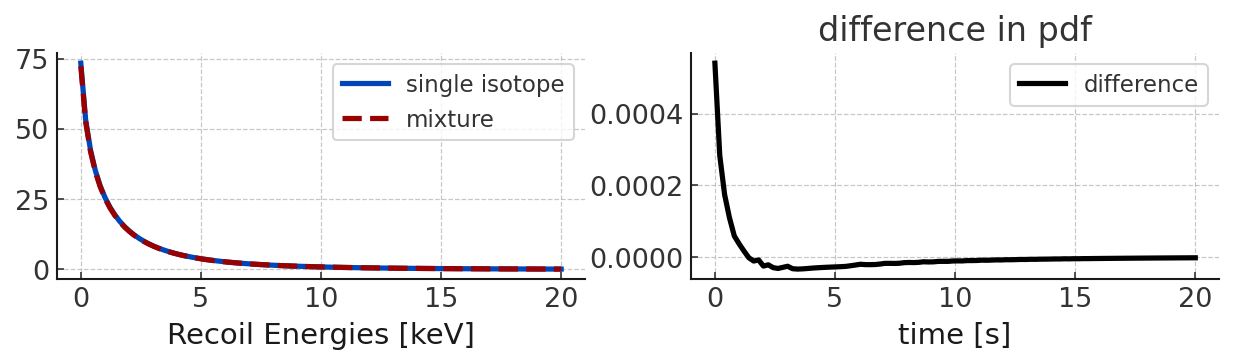

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,2))
ax1.plot(Int2.recoil_energies, a['Total'], label='single isotope')
ax1.plot(Int.recoil_energies, c['Total'], label='mixture', ls='--');
ax1.set_xlabel('Recoil Energies [keV]')
ax1.legend(fontsize=11);

e = a['Total']/np.sum(a['Total']) - c['Total']/np.sum(c['Total'])
ax2.plot(Int.recoil_energies, e, color='k', label='difference')
ax2.set_title("difference in pdf")
ax2.set_xlabel('time [s]')
ax2.legend(fontsize=11);

### Sampling dependently
Let's sample first a time, and at that time, a _valid_ neutrino energy, and for that neutrino energy corresponding recoil energy. <br>
For details please see the "Proper-time-energy-sampling.ipynb" notebook under multimessenger/notebooks

In [47]:
from multimessenger.supernova import Simulate

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [50]:
sampled_times, sampled_neutrino_energies, sampled_recoils = Simulate.sample_times_energies(Int2, size=[28,28,68,68])

NU_E:   0%|          | 0/28 [00:00<?, ?it/s]

NU_E_BAR:   0%|          | 0/28 [00:00<?, ?it/s]

NU_X:   0%|          | 0/68 [00:00<?, ?it/s]

NU_X_BAR:   0%|          | 0/68 [00:00<?, ?it/s]

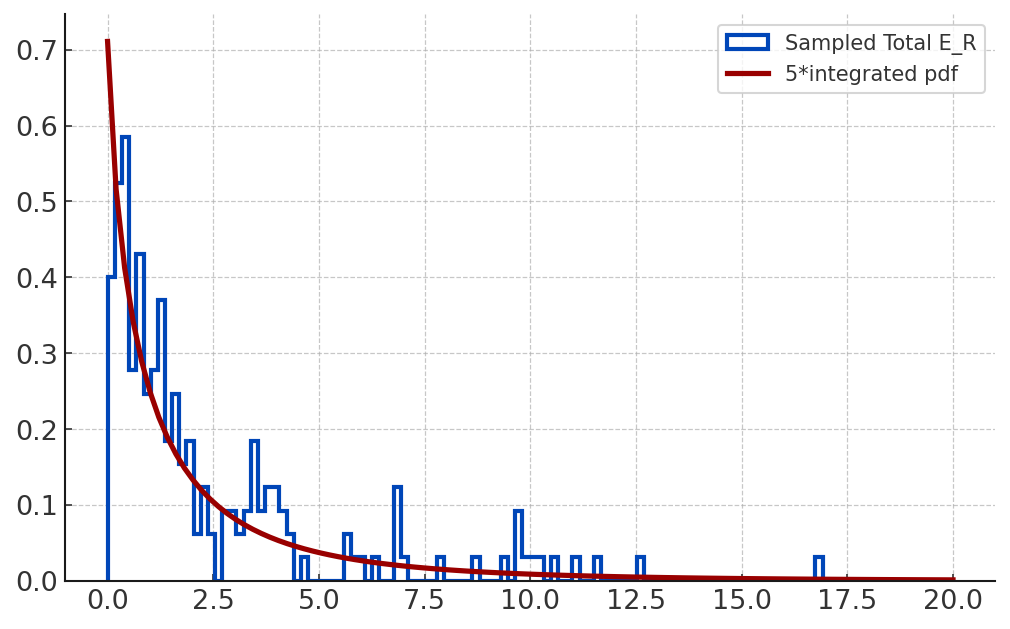

In [67]:
# for f in Flavor:
#     plt.hist(sampled_recoils[f], bins=10, histtype='step', density=1, label=f.name);
plt.hist(sampled_recoils["Total"], bins=100, histtype='step', density=1, label='Sampled Total E_R', lw=2);
plt.plot(Int.recoil_energies, Int.rates_per_recoil['Total']/np.sum(Int.rates_per_recoil['Total'])*5, label='5*integrated pdf')
plt.legend();

$\frac{dR}{dE_R} = \sum_{\nu_\beta} N_{Xe}
               \int_{E_{min}^{\nu}} dE_\nu f_\nu(E_\nu)\frac{d\sigma}{dE_R}(E_\nu, E_R)$
               
$\frac{dR}{dt} = \sum N_{Xe}\int_{E_{min}^\nu} = f_\nu(E_\nu,t)
               \int_{E_{R}^{min}}^{E_{R}^{max}} dE_R \frac{d\sigma}{dE_R}(E_\nu, E_R)$